In [21]:
#!pip install pydataset
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from pydataset import data

In [22]:
df=data('Housing')

In [40]:
df.sample(3)

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
297,0,5900,2,1,1,1,0,0,0,0,1,0
48,0,3090,3,1,2,0,0,0,0,0,0,0
343,2,10500,2,1,1,1,0,0,0,0,1,0


In [24]:
df.head(2).values

array([[42000.0, 5850, 3, 1, 2, 'yes', 'no', 'yes', 'no', 'no', 1, 'no'],
       [38500.0, 4000, 2, 1, 1, 'yes', 'no', 'no', 'no', 'no', 0, 'no']],
      dtype=object)

In [25]:
#{'no':0,"yes":1}
d = dict(zip(['no', 'yes'], range(0,2)))

In [26]:
# zipped tuple will be ('price', dtype('float64')
for i in zip(df.dtypes.index, df.dtypes):
    if str(i[1]) == 'object':
        df[i[0]] = df[i[0]].map(d)

In [27]:
for i, j in enumerate(np.unique(pd.qcut(df['price'],3))):
    print(i,j)

0 (24999.999, 53000.0]
1 (53000.0, 74500.0]
2 (74500.0, 190000.0]


In [28]:
df['price']=pd.qcut(df['price'],3,labels=['0','1','2'],duplicates='drop').cat.codes

In [29]:
#split into two sets
y=df['price']
X=df.drop('price',1)

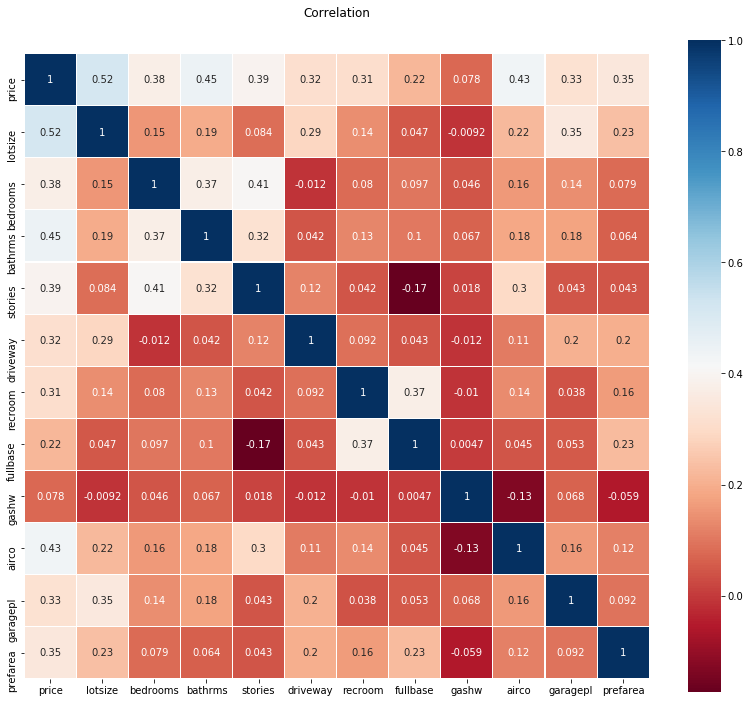

In [30]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation', y=1.05, size=12)
sns.heatmap(df.astype(float).corr(),linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

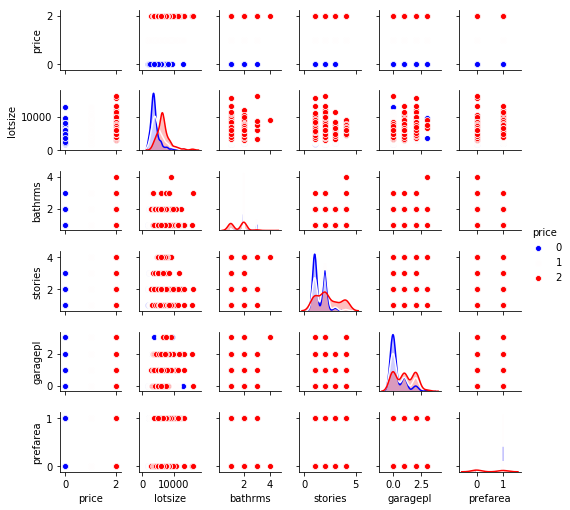

In [39]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sns.pairplot(df[['price', 'lotsize', 'bathrms', 'stories', 'garagepl', 'prefarea']], 
                 hue='price', palette = 'seismic',size=1.2, diag_kind = 'kde')

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [33]:
seed = 1075
np.random.seed(seed)
rf=RandomForestClassifier()
et=ExtraTreesClassifier()
knn=KNeighborsClassifier()
svc=SVC()
rg=RidgeClassifier()
clf_array=[rf,et,knn,svc,rg]
for clf in clf_array:
    vanilla_scores=cross_val_score(clf,X, y, cv=10, n_jobs=-1)
                                  
    bagging_clf=BaggingClassifier(clf,max_samples=0.4, max_features=10,
                                  random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10, 
       n_jobs=-1)
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]"  
                       .format(clf.__class__.__name__, 
                       vanilla_scores.mean(), vanilla_scores.std()))
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n"
                       .format(clf.__class__.__name__, 
                        bagging_scores.mean(), bagging_scores.std()))
    

Mean of: 0.645, std: (+/-) 0.099 [RandomForestClassifier]
Mean of: 0.639, std: (+/-) 0.069 [Bagging RandomForestClassifier]

Mean of: 0.621, std: (+/-) 0.105 [ExtraTreesClassifier]
Mean of: 0.654, std: (+/-) 0.073 [Bagging ExtraTreesClassifier]

Mean of: 0.500, std: (+/-) 0.086 [KNeighborsClassifier]
Mean of: 0.535, std: (+/-) 0.111 [Bagging KNeighborsClassifier]

Mean of: 0.465, std: (+/-) 0.085 [SVC]
Mean of: 0.535, std: (+/-) 0.083 [Bagging SVC]

Mean of: 0.639, std: (+/-) 0.050 [RidgeClassifier]
Mean of: 0.597, std: (+/-) 0.045 [Bagging RidgeClassifier]



In [34]:

# votingClassifier-hard voting
from sklearn.ensemble import VotingClassifier
clf=[rf,et,knn,svc,rg]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), 
                                    ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')
    for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 
                                                     'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
        scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
        print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))



Mean: 0.619, std: (+/-) 0.078 [Random Forest]
Mean: 0.640, std: (+/-) 0.090 [Extra Trees]
Mean: 0.500, std: (+/-) 0.086 [KNeighbors]
Mean: 0.465, std: (+/-) 0.085 [SVC]
Mean: 0.639, std: (+/-) 0.050 [Ridge Classifier]
Mean: 0.632, std: (+/-) 0.102 [Ensemble]


In [38]:
# Set up ensemble voting for bagging
ebclf_array = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for clf in clf_array:
        ebclf_array.append(BaggingClassifier(clf, max_samples=0.25, 
                                       max_features=10, random_state=seed))

    v_eclf = VotingClassifier(estimators=list(zip(['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                                              'Bagging SVC', 'Bagging Ridge Classifier', 'Bagging Ensemble'],
                                             ebclf_array)), 
                              voting='hard')

    ebclf_array.append(v_eclf)

    for clf, label in zip(ebclf_array, ['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                                  'Bagging SVC', 'BaggingRidge Classifier', 'Bagging Ensemble']):
        scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
        print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.661, std: (+/-) 0.099 [Bagging Random Forest]
Mean: 0.650, std: (+/-) 0.082 [Bagging Extra Trees]
Mean: 0.535, std: (+/-) 0.117 [Bagging KNeighbors]
Mean: 0.528, std: (+/-) 0.068 [Bagging SVC]
Mean: 0.604, std: (+/-) 0.046 [BaggingRidge Classifier]
Mean: 0.658, std: (+/-) 0.091 [Bagging Ensemble]


In [47]:
#Boosting
#!pip install mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
import warnings
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

warnings.filterwarnings('ignore')

# Create boosting classifiers
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

boost_array = [ada_boost, grad_boost, xgb_boost]

eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.641, std: (+/-) 0.082 [Ada Boost]
Mean: 0.654, std: (+/-) 0.113 [Grad Boost]
Mean: 0.663, std: (+/-) 0.101 [XG Boost]
Mean: 0.665, std: (+/-) 0.104 [Ensemble]


In [46]:
#!pip install mlens
from mlens.ensemble import SuperLearner
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr = LogisticRegression()

seed = 1075

ensemble = SuperLearner(scorer = accuracy_score, 
                        random_state=seed, 
                        folds=10,
                        verbose = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

# Build the first layer
ensemble.add([rf, et, knn, rg])
# Attach the final meta estimator
ensemble.add_meta(lr)

ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)
print("Fit data:\n%r" % ensemble.data)
print("Accuracy score: {:.3f}".format(accuracy_score(preds, y_test)))


Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:03

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01
Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  extratreesclassifier         0.66     0.10  0.79  0.18  0.07  0.04
layer-1  kneighborsclassifier         0.51     0.07  0.04  0.02  0.04  0.02
layer-1  randomforestclassifier       0.66     0.06  0.80  0.08  0.02  0.01
layer-1  ridgeclassifier              0.65     0.08  0.05  0.02  0.01  0.00

Accuracy score: 0.669
